# 분류와 군집(Classfication & Clustering)

In [181]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings(action='ignore') 

# 1. 분류(Multinomial naive Bayes, tfidf)
- Naive Bayes는 고차원(High dimensionality)이 text classification에 적합
- Corpus에서 추출된 단어를 특성변수로 해당 단어의 출현빈도를 변수(컬럼)의 데이터로 vetorization 
- 20 Newsgroups corpus를 사용하여 3개의 그룹으로 분류하는 예제

## 1.1 데이터 불러오기

In [3]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
type(data)

sklearn.utils.Bunch

실습을 위해 20개의 기사그룹에서 3개(종교, 우주, 컴퓨터그래픽) topic만을 데이터로 추출

In [7]:
'//'.join(data.target_names)

'alt.atheism//comp.graphics//comp.os.ms-windows.misc//comp.sys.ibm.pc.hardware//comp.sys.mac.hardware//comp.windows.x//misc.forsale//rec.autos//rec.motorcycles//rec.sport.baseball//rec.sport.hockey//sci.crypt//sci.electronics//sci.med//sci.space//soc.religion.christian//talk.politics.guns//talk.politics.mideast//talk.politics.misc//talk.religion.misc'

In [81]:
categories = ['soc.religion.christian','sci.space', 'comp.graphics', 'rec.autos']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [82]:
data = fetch_20newsgroups(categories=categories)
data.keys()
data.target_names

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

['comp.graphics', 'rec.autos', 'sci.space', 'soc.religion.christian']

In [83]:
df = pd.DataFrame(data.data, columns=['contents'])
df['target'] = data.target
df.shape
df.head()

(2370, 2)

,contents,target
0,From: henry@zoo.toronto.edu (Henry Spencer)\nS...,2
1,From: jchen@wind.bellcore.com (Jason Chen)\nSu...,1
2,From: jasons@atlastele.com (Jason Smith)\nSubj...,3
3,From: ak296@yfn.ysu.edu (John R. Daker)\nSubje...,1
4,From: lorenzo@rintintin.Colorado.EDU (Eric Lor...,1


In [84]:
df['contents'][0]

"From: henry@zoo.toronto.edu (Henry Spencer)\nSubject: Re: Command Loss Timer (Re: Galileo Update - 04/22/93)\nOrganization: U of Toronto Zoology\nLines: 17\n\nIn article <1993Apr23.103038.27467@bnr.ca> agc@bmdhh286.bnr.ca (Alan Carter) writes:\n>|> ... a NO-OP command was sent to reset the command loss timer ...\n>\n>This activity is regularly reported in Ron's interesting posts. Could\n>someone explain what the Command Loss Timer is?\n\nIf I'm not mistaken, this is the usual sort of precaution against loss of\ncommunications.  That timer is counting down continuously; if it ever hits\nzero, that means Galileo hasn't heard from Earth in a suspiciously long\ntime and it may be Galileo's fault... so it's time to go into a fallback\nmode that minimizes chances of spacecraft damage and maximizes chances\nof restoring contact.  I don't know exactly what-all Galileo does in such\na situation, but a common example is to switch receivers, on the theory\nthat maybe the one you're listening wit

## 1.2 데이터 전처리

특수 문자 제거

In [85]:
df['contents'] = df['contents'].str.replace("[^a-zA-Z]", " ")

단어의 길이가 2이하는 제거

In [86]:
df['contents'] = df['contents'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

전체 단어를 소문자로 변환

In [87]:
df['contents'] = df['contents'].apply(lambda x: x.lower())

In [88]:
df['contents'][0]

'from henry zoo toronto edu henry spencer subject command loss timer galileo update organization toronto zoology lines article apr bnr agc bmdhh bnr alan carter writes command was sent reset the command loss timer this activity regularly reported ron interesting posts could someone explain what the command loss timer not mistaken this the usual sort precaution against loss communications that timer counting down continuously ever hits zero that means galileo hasn heard from earth suspiciously long time and may galileo fault time into fallback mode that minimizes chances spacecraft damage and maximizes chances restoring contact don know exactly what all galileo does such situation but common example switch receivers the theory that maybe the one you listening with has died all work one man work henry spencer toronto zoology kipling henry zoo toronto edu utzoo henry'

## 1.3 불용어 처리(Stopwords)

In [46]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english') # NLTK로부터 불용어를 다운

tokenized_doc = df['contents'].apply(lambda x: x.split()) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [48]:
tokenized_doc[0:2]

0    [pyron, skndiv, dseg, dillon, pyron, subject, ...
1    [nusunix, ling, siew, subject, online, bible, ...
Name: contents, dtype: object

불용어 제거를 위해 토큰화 작업을 수행하였지만, TfidfVectorizer 토큰화가 되어있지 않은 텍스트 데이터를 입력으로 사용하기 위해
 * 토큰화 작업을 역으로 취소하는 작업을 수행: 역토큰화(Detokenization)

In [52]:
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df['contents'] = detokenized_doc

In [53]:
df['contents'][0]

'pyron skndiv dseg dillon pyron subject give billion first year long moon residents lines nntp posting host skndiv dseg reply pyron skndiv dseg organization dseg support article kinnpas schaefer peter schaefer writes article aurora alaska nsmca aurora alaska writes article theporch raider gene theporch raider gene wright writes continuin talk space complaints government large cost something read might work announce reward billion would first corporation successfully keeps least person alive moon year inexpensive popular technologies begin developed different kind space race gene theporch raider gene wright theporch raider macinteresteds nashville true friends could pool resources maybe make prize kind liek solar race australia anybody game contest michael adams nsmca acad alaska high jacked billion dollars enough cover cost feasability study happy happy feasability study wimp studying others would damn many engineers little engineering sits arse sits fortune richard francis burton dill

## 1.3 훈련과 검증데이터 구분

In [89]:
X = df['contents']
y = df['target']

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 1.4 문자를 vectorization하는 방법

#### 1.4.1 CountVectorizer : 각 문서에 나타난 단어의  출현 빈도

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(df['contents'])
X
X.toarray()

<2370x30309 sparse matrix of type '<class 'numpy.int64'>'
	with 314057 stored elements in Compressed Sparse Row format>

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [92]:
pd.DataFrame(X.toarray(), columns=vec.get_feature_names()).head(3)

,aaa,aaaa,aacc,aad,aalborg,aamir,aamrl,aams,aan,aangeboden,...,zwaartepunten,zwak,zwakke,zware,zwart,zwarte,zxa,zyeh,zyxel,zzpn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 1.4.2. TF–IDF
- CountVectorizer 방식의 단점은 너무 자주 나오는 단어에 가중치가 높아져 sub-optimal in some classification algorithms.
- 이러한 점을 보완하기 위해 *term frequency-inverse document frequency* (*TF–IDF*) 

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(df['contents'])
pd.DataFrame(X.toarray(), columns=vec.get_feature_names()).head(3)

,aaa,aaaa,aacc,aad,aalborg,aamir,aamrl,aams,aan,aangeboden,...,zwaartepunten,zwak,zwakke,zware,zwart,zwarte,zxa,zyeh,zyxel,zzpn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.5 TF-IDF와 multinomial naive Bayes로 pipeline 구성

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

파이프라인을 데이터에 적용하여 예측하면

In [95]:
model.fit(X_train, y_train)
y_predict = model.predict(test.data)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

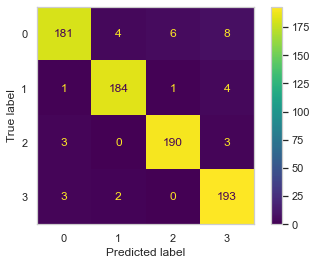

In [96]:
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)

새로운 기사를 받아 분류를 예측해보자

In [106]:
y_pred = model.predict(['Repent, for the kindom of heaven os near'])
y_pred

array([3], dtype=int64)

In [107]:
train.target_names

['comp.graphics', 'rec.autos', 'sci.space', 'soc.religion.christian']

In [108]:
train.target_names[y_pred[0]]

'soc.religion.christian'

####  <font color='blue'> 각 단어의 빈도로 예측이 거의 완벽하게 분류한다.  naive algorithm은 대용량 high-dimensional text 자료에 잘 사용할 경우 언비리버블하게 잘 예측한다

# 2. LDA, Topic modeling

- LDA는 문서의 집합으로부터 어떤 토픽이 존재하는지를 알아내기 위한 알고리즘
- LDA는 빈도수 기반의 표현 방법인 Countvecot 또는 TF-IDF 행렬을 입력
   * LDA는 문서의 단어 출현 순서와는 무관

모든 문서(기사)가 작성될 때 문서 작성자는 '나는 이 문서를 작성하기 위해서 이런 주제들을 넣을거고, 이런 주제들을 위해서는 이런 단어들을 넣을 거야.'이런 과정을 거쳐서 작성되었다고 가정

- (1) 문서에 사용할 단어의 개수 N을 설정
- (2) 문서에 사용할 토픽의 혼합을 확률 분포에 기반하여 결정하여 문서 작성
- (3) 문서에 사용할 각 단어를 작가는 정한다고 가정
       * 3-1) 토픽 분포에서 토픽 T를 확률적으로 고릅니다.
            * 60% 확률로 종교 토픽을 선택하고, 40% 확률로 다른 토픽을 선택
       * 3-2) 선택한 토픽 T에서 단어의 출현 확률 분포에 기반해 문서에 사용할 단어를 고릅니다.
            * 종교 토픽을 선택하였다면, 80% 확률로 예수 단어를 선택하여 (3)을 반복하면서 문서를 완성하였을 것이다.

이런한 문서 작성 가정을 전제로 LDA는 토픽을 뽑아내기 위하여 위 과정을 역으로 추적하는 역공학(reverse engneering)

### 2.1. 데이터 불러오기
- 20개의 뉴스그룹에서 7개의 뉴스토픽을 추출

In [201]:
data = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [202]:
topics = data.target_names[1::3]
topics

['comp.graphics',
 'comp.sys.mac.hardware',
 'rec.autos',
 'rec.sport.hockey',
 'sci.med',
 'talk.politics.guns',
 'talk.religion.misc']

In [203]:
dataset = fetch_20newsgroups(shuffle=True, categories=categories, 
                             random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

2370

### 2.2. 텍스트 전처리

In [204]:
news_df = pd.DataFrame({'document':documents})
news_df.head()

,document
0,I am presently doing a masters thesis to do wi...
1,"\n\n TRIAD, the first drag-free satellite,..."
2,Les Bartel's comments:\n\nLet me add my .02 in...
3,\n\nRumor has it that a guy at Dell Computer h...
4,Biblical basis for the Immaculate Conception:\...


In [205]:
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [206]:
news_df.head()

,document,clean_doc
0,I am presently doing a masters thesis to do wi...,presently doing masters thesis with traffic in...
1,"\n\n TRIAD, the first drag-free satellite,...",triad first drag free satellite designed built...
2,Les Bartel's comments:\n\nLet me add my .02 in...,bartel comments installed ford garage work wel...
3,\n\nRumor has it that a guy at Dell Computer h...,rumor that dell computer miata totalled that w...
4,Biblical basis for the Immaculate Conception:\...,biblical basis immaculate conception will enmi...


In [207]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english') # NLTK의 불용어
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) # 불용어를 제거

In [208]:
type(tokenized_doc)
tokenized_doc[0:2]

pandas.core.series.Series

0    [presently, masters, thesis, traffic, intersec...
1    [triad, first, drag, free, satellite, designed...
Name: clean_doc, dtype: object

### 2.3. TF-IDF 행렬 만들기
불용어 제거를 위해 토큰화 작업을 수행하였지만, TfidfVectorizer(TF-IDF 챕터 참고)는 기본적으로 토큰화가 되어있지 않은 텍스트 데이터를 입력으로 사용합니다. 그렇기 때문에 TfidfVectorizer를 사용해서 TF-IDF 행렬을 만들기 위해서 news_df['clean_doc']컬럼을 사용


In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # 상위 1,000개의 단어를 보존 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])
X.shape # TF-IDF 행렬의 크기 확인

(2370, 1000)

### 2.4. 토픽 모델링(Topic Modeling), ㅣLDA(Latent Dirichlet Allocation, LDA)

In [210]:
tokenized_doc[:5]  # 불용어 처리된 기사

0    [presently, masters, thesis, traffic, intersec...
1    [triad, first, drag, free, satellite, designed...
2    [bartel, comments, installed, ford, garage, wo...
3      [rumor, dell, computer, miata, totalled, would]
4    [biblical, basis, immaculate, conception, enmi...
Name: clean_doc, dtype: object

이제 각 단어에 정수 인코딩을 하는 동시에, 각 뉴스에서의 단어의 빈도수를 기록해보겠습니다. 여기서는 각 단어를 (word_id, word_frequency)의 형태로 바꾸고자 합니다. word_id는 단어가 정수 인코딩된 값이고, word_frequency는 해당 뉴스에서의 해당 단어의 빈도수를 의미합니다. 이는 gensim의 corpora.Dictionary()를 사용하여 손쉽게 구할 수 있습니다. 전체 뉴스에 대해서 정수 인코딩을 수행하고, 두번째 뉴스를 출력해봅시다.

In [211]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
print(corpus[1]) # 수행된 결과에서 두번째 뉴스 출력. 첫번째 문서의 인덱스는 0

[(25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 3), (43, 1), (44, 3), (45, 1), (46, 2), (47, 2), (48, 2), (49, 1), (50, 3), (51, 1), (52, 1), (53, 2), (54, 2), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 3), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 3), (75, 1), (76, 5), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 4), (96, 1), (97, 1), (98, 1)]


두번째 뉴스의 출력 결과를 봅시다. 위의 출력 결과 중에서 (66, 2)는 정수 인코딩이 66으로 할당된 단어가 두번째 뉴스에서는 두 번 등장하였음을 의미합니다. 66이라는 값을 가지는 단어가 정수 인코딩이 되기 전에는 어떤 단어였는지 확인하여봅시다. 이는 dictionary[]에 기존 단어가 무엇인지 알고자하는 정수값을 입력하여 확인할 수 있습니다.

In [212]:
print(dictionary[66])

nova


In [213]:
len(dictionary)

23308

뉴스 토픽의 개수를 7개로 하여 LDA 모델을 학습

In [214]:
import gensim
from tqdm import tqdm_notebook

NUM_TOPICS = 7 #20개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in tqdm_notebook(topics):
    print(topic)

  0%|          | 0/7 [00:00<?, ?it/s]

(0, '0.013*"data" + 0.009*"image" + 0.006*"nasa" + 0.006*"images"')
(1, '0.008*"would" + 0.007*"graphics" + 0.006*"like" + 0.005*"search"')
(2, '0.023*"space" + 0.015*"launch" + 0.008*"satellite" + 0.007*"commercial"')
(3, '0.008*"would" + 0.005*"jesus" + 0.005*"radius" + 0.004*"body"')
(4, '0.010*"would" + 0.008*"people" + 0.006*"think" + 0.006*"jesus"')
(5, '0.009*"thanks" + 0.009*"know" + 0.008*"would" + 0.007*"anyone"')
(6, '0.006*"like" + 0.005*"first" + 0.005*"would" + 0.005*"time"')


In [215]:
', '.join(data.target_names)

'alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc'

In [216]:
print(ldamodel.print_topics())

[(0, '0.013*"data" + 0.009*"image" + 0.006*"nasa" + 0.006*"images" + 0.006*"software" + 0.006*"space" + 0.005*"graphics" + 0.005*"available" + 0.005*"information" + 0.004*"also"'), (1, '0.008*"would" + 0.007*"graphics" + 0.006*"like" + 0.005*"search" + 0.004*"find" + 0.004*"could" + 0.003*"know" + 0.003*"also" + 0.003*"thanks" + 0.003*"black"'), (2, '0.023*"space" + 0.015*"launch" + 0.008*"satellite" + 0.007*"commercial" + 0.005*"year" + 0.005*"market" + 0.004*"satellites" + 0.004*"technology" + 0.004*"also" + 0.004*"system"'), (3, '0.008*"would" + 0.005*"jesus" + 0.005*"radius" + 0.004*"body" + 0.004*"good" + 0.004*"like" + 0.004*"tomb" + 0.003*"even" + 0.003*"think" + 0.003*"point"'), (4, '0.010*"would" + 0.008*"people" + 0.006*"think" + 0.006*"jesus" + 0.005*"know" + 0.005*"christ" + 0.005*"also" + 0.005*"church" + 0.005*"faith" + 0.004*"like"'), (5, '0.009*"thanks" + 0.009*"know" + 0.008*"would" + 0.007*"anyone" + 0.007*"like" + 0.006*"files" + 0.006*"program" + 0.006*"graphics" + 

## LDA 시각화 하기

In [217]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

# 3. K-means Clustering

### 3.1. 데이터 불러오기
- 20개의 뉴스그룹에서 7개의 뉴스토픽을 추출

In [281]:
data = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [282]:
topics = data.target_names[0::2]
topics

['alt.atheism',
 'comp.os.ms-windows.misc',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.motorcycles',
 'rec.sport.hockey',
 'sci.electronics',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.misc']

In [283]:
dataset = fetch_20newsgroups(shuffle=True, categories=topics, 
                             random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

5627

### 3.2. 텍스트 전처리

In [284]:
news_df = pd.DataFrame({'document':documents, 'target': dataset.target})
news_df.head()
news_df.target.value_counts()

,document,target
0,improve these kids' chances>>of getting anothe...,9
1,,5
2,So-Called Cool-Hot boxes have been advetised ...,6
3,\n\nThere are several problems with the way th...,5
4,\n\nWait a minute. I agree with you that peop...,9


5    600
4    598
7    593
1    591
6    591
3    585
2    578
8    546
0    480
9    465
Name: target, dtype: int64

In [285]:
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

### 3.3. TF-IDF 행렬 만들기
불용어 제거를 위해 토큰화 작업을 수행하였지만, TfidfVectorizer(TF-IDF 챕터 참고)는 기본적으로 토큰화가 되어있지 않은 텍스트 데이터를 입력으로 사용합니다. 그렇기 때문에 TfidfVectorizer를 사용해서 TF-IDF 행렬을 만들기 위해서 news_df['clean_doc']컬럼을 사용


In [286]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features= 1000, # 상위 1,000개의 단어를 보존
                             max_df = 0.5, 
                             smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])
X.shape # TF-IDF 행렬의 크기 확인

(5627, 1000)

### 3.2 Clustering
- 클러스터의 그룹 개수는 10개(news_df.target.nunique())

In [267]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=news_df.target.nunique(), random_state=0).fit(X.toarray())
kmeans.cluster_centers_
kmeans.labels_

array([[ 7.48000552e-03,  3.53245723e-05,  1.73472348e-18, ...,
         9.20962225e-03,  6.98063816e-03,  4.89891965e-03],
       [ 8.22595732e-03,  3.89413467e-03,  2.36927693e-03, ...,
         4.56702178e-03,  2.66612049e-03,  2.10106400e-03],
       [ 4.45129482e-03,  1.72142175e-03,  3.44038511e-03, ...,
         2.00500804e-03,  1.36796435e-03,  9.32973685e-04],
       ...,
       [ 7.34214476e-03,  4.62057714e-03,  1.01266038e-03, ...,
         5.60752252e-04,  2.27154794e-03,  1.71964668e-03],
       [ 8.44509869e-03,  5.44961818e-04,  2.41692134e-03, ...,
         0.00000000e+00,  4.68947275e-03,  1.41354503e-03],
       [ 6.59409115e-03,  4.33680869e-19,  9.47728230e-03, ...,
         6.06231618e-04,  2.39223599e-03, -2.16840434e-19]])

array([7, 2, 7, ..., 0, 2, 3])

### 3.3 성능 확인

In [268]:
news_df['k_means'] = kmeans.labels_
news_df.target.unique()
news_df['k_means'].unique()

array([9, 5, 6, 8, 3, 7, 1, 2, 4, 0], dtype=int64)

array([7, 2, 1, 4, 5, 3, 8, 6, 0, 9])

In [270]:
for i, j in news_df.groupby('target'):
    j.head()

,document,target,k_means,clean_doc
18,\nFred Rice answered this already in an early ...,0,7,fred rice answered this already early posting ...
28,\n\nAHA! He admits it! He IS a moral relativis...,0,7,admits moral relativist keith start wafffling ...
30,I don't think there is really any question abo...,0,7,think there really question about which courts...
36,"\nNope, Germany has extremely restrictive citi...",0,2,nope germany extremely restrictive citizenship...
39,\nI'll take a wild guess and say Freedom is ob...,0,2,take wild guess freedom objectively valuable b...


,document,target,k_means,clean_doc
12,\nIt also runs OS/2 character based apps and P...,1,3,also runs character based apps posix apps wind...
15,"Whenever I start File Manager, the status bar ...",1,2,whenever start file manager status displayed e...
16,"Well, I'm amazed at how successful this exerci...",1,3,well amazed successful this exercise received ...
43,\n[stuff about changing windows registration o...,1,3,stuff about changing windows registration omitted
53,I remember reading about a program that made w...,1,3,remember reading about program that made windo...


,document,target,k_means,clean_doc
13,\nHere is a list of the FirstClass systems in ...,2,2,here list firstclass systems illinois chicago ...
22,Greetings!!\n\n\tI planning to upgrade my Mac ...,2,5,greetings planning upgrade iisi from present m...
23,I am seeking recommendations/Vendors for a Net...,2,5,seeking recommendations vendors networkable wo...
24,\n,2,2,
33,\n\nWhat's the latest version of Stepping Out ...,2,2,what latest version stepping that works with


,document,target,k_means,clean_doc
6,"I am looking for a 286 motherboard, preferable...",3,4,looking motherboard preferable also looking ca...
11,"Posting for a friend: please call Steve, 415 2...",3,5,posting friend please call steve interested se...
35,I am posting this message for a friend of mine...,3,2,posting this message friend mine does have com...
41,"Hi netters,\n\nDoes anyone know have any info ...",3,5,netters does anyone know have info ultrastor l...
55,"If anyone has Joe Venuti's record ""Fiddle on F...",3,2,anyone venuti record fiddle fire would like se...


,document,target,k_means,clean_doc
14,I was wondering if anybody knows anything abou...,4,8,wondering anybody knows anything about yamaha ...
20,"\nHell, just save your candle stubs and bring ...",4,7,hell just save your candle stubs bring them li...
21,"\nThree, actually. I believe I discussed coun...",4,2,three actually believe discussed countersteeri...
25,"\n\nDenmark, eh? Should have taken a short sw...",4,2,denmark should have taken short sword cleaved ...
27,"\n\tAgreed, but, yes, chapstick fits under the...",4,7,agreed chapstick fits under waxy shit category...


,document,target,k_means,clean_doc
1,,5,2,
3,\n\nThere are several problems with the way th...,5,2,there several problems with game being present...
10,"OK, I'll join in the fun and give my playoff p...",5,2,join give playoff predictions round pitt pitt ...
17,"For updated playoff updates (scores, stats, su...",5,5,updated playoff updates scores stats summaries...
34,Could anyone recommend a mail order distributo...,5,5,could anyone recommend mail order distributor ...


,document,target,k_means,clean_doc
2,So-Called Cool-Hot boxes have been advetised ...,6,7,called cool boxes have been advetised several ...
8,\n\n\n\n\nI've had very good results from the ...,6,2,very good results from from part analogue devi...
26,\n)Do you know what frequencies chanels 17 to ...,6,2,know what frequencies chanels what usually all...
31,\n\nAssuming 68HC11...\nIn expanded muxed mode...,6,2,assuming expanded muxed mode could much easier...
32,"Hello, \n\n Let me introduce a problem:\n\n ...",6,6,hello introduce problem when measure sinusoida...


,document,target,k_means,clean_doc
7,That is an idea.. The most efficient moon habi...,7,1,that idea most efficient moon habitat also ide...
42,"\nActually, the reboost will probably be done ...",7,9,actually reboost will probably done last that ...
47,From: Gene Wright <gene@theporch.raider.net>\n...,7,2,from gene wright gene theporch raider imagine ...
48,...\n\nFunny. A bit disturbing. Forging a po...,7,9,funny disturbing forging posting seems somewha...
88,\n\nHe's also the one who dubbed it the SR-71 ...,7,2,also dubbed until mippselled fwiw doug page


,document,target,k_means,clean_doc
5,Actually not Jim. I just said that everyone e...,8,7,actually just said that everyone else seemed h...
9,[This is a co-authored report from two of us w...,8,1,this authored report from were there owners ac...
29,\n The relevance is that if you've got x...,8,1,relevance that homicides reduce number homicid...
57,":\n:So much for ""infinite patience.""\n: \n;I f...",8,1,much infinite patience find hard swallow that ...
85,Re: More on Gun Buybacks\n\nThe Denver buy bac...,8,1,more buybacks denver back trading guns denver ...


,document,target,k_means,clean_doc
0,improve these kids' chances>>of getting anothe...,9,7,improve these kids chances getting another fut...
4,\n\nWait a minute. I agree with you that peop...,9,1,wait minute agree with that people have take r...
19,\nFine. Libertarians and anarchists are not a...,9,1,fine libertarians anarchists alone being uncom...
45,>>>Does the greatly increased rates of inc...,9,1,does greatly increased rates incarceration amo...
58,\nNo one is questioning whether Mr. King is bl...,9,7,questioning whether king black question arises...


### 3.4 silhouette_visualizer

#### yellowbrick 설치 및 예제, conda install yellowbrick

In [290]:
pwd

'd:\\HMOT\\scripts'

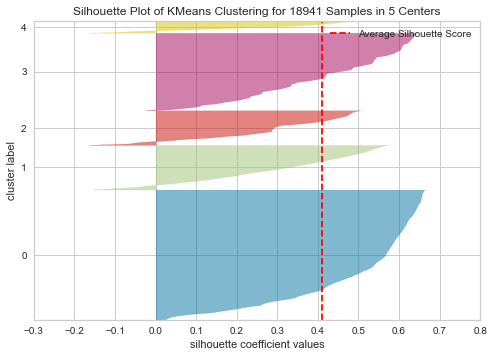

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 18941 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, random_state=42))

In [275]:
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.datasets import load_credit

# Load a clustering dataset
x, y = load_credit()

# Specify rows to cluster: under 40 y/o and have either graduate or university education
x = x[(x['age'] <= 40) & (x['edu'].isin([1,2]))]

# Use the quick method and immediately show the figure
silhouette_visualizer(KMeans(5, random_state=42), x, colors='yellowbrick')

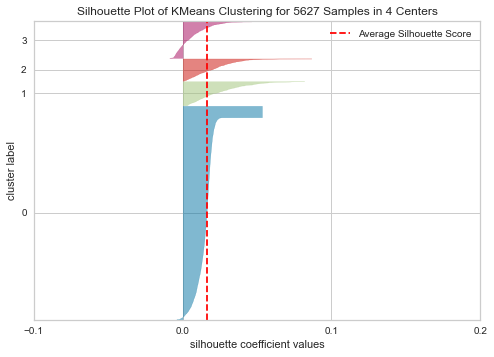

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5627 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=42))

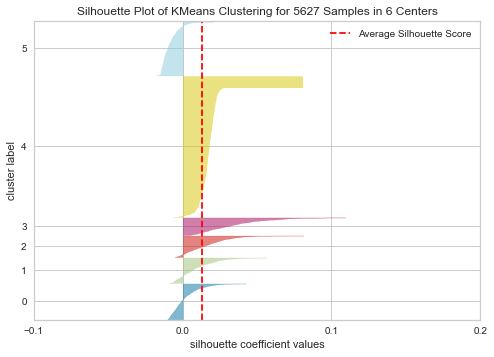

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5627 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=6, random_state=42))

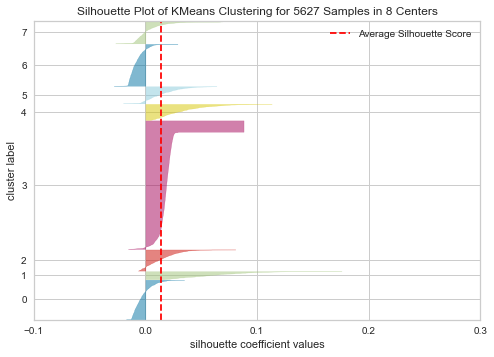

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5627 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick', estimator=KMeans(random_state=42))

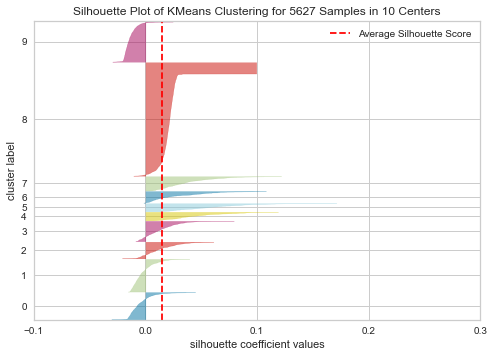

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5627 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=10, random_state=42))

In [289]:
for i in [4,6,8,10]:
    silhouette_visualizer(KMeans(i, random_state=42), X.toarray(), colors='yellowbrick')